<a href="https://colab.research.google.com/github/lianpeled/MRI-Compression-with-PCA-and-Autoencoders/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from sklearn.feature_selection import r_regression
import keras
from keras import layers, models

In [3]:
flatmat = np.loadtxt('/content/drive/MyDrive/1 Image Processing Project/Data/Matrix/T1_slice80')
mat = flatmat.reshape(757, 182, 218)

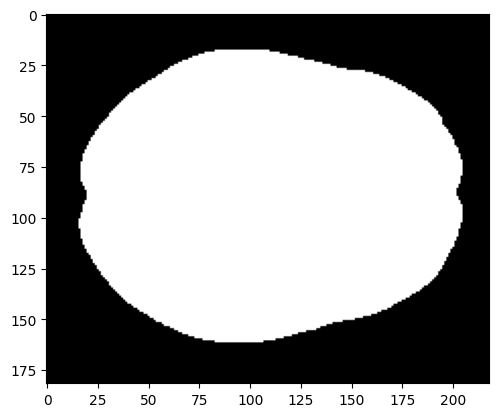

In [4]:
mask_path = '/content/drive/MyDrive/1 Image Processing Project/Data/Mask/MNI152_T1_1mm_Brain_Mask.nii'
brain_mask = nib.load(mask_path).get_fdata()[:,:,80]
plt.imshow(brain_mask, cmap = 'gray')


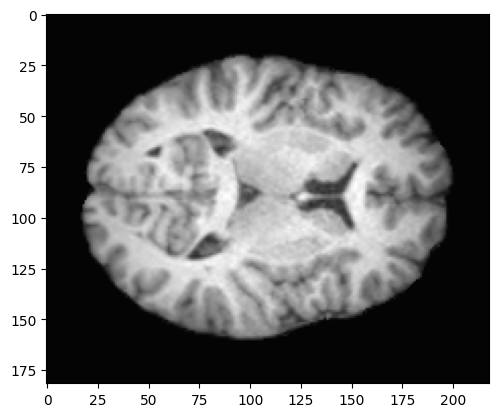

In [5]:
for i in range(mat.shape[0]):
  mat[i] = mat[i] * brain_mask
plt.imshow(mat[0], cmap = 'gray')

In [6]:
# 0-1 normalization
for i in range(mat.shape[0]):
    mat[i] = (mat[i]- mat[i].min()) / ((mat[i]).max() - mat[i].min())

In [7]:
# build the AE

input = keras.layers.Input(shape=(182,218,1,))

encoded = keras.layers.Conv2D(32, (3, 3), padding='same')(input)
encoded = keras.layers.BatchNormalization()(encoded)
encoded = keras.layers.Activation('relu')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding="same")(encoded)
encoded = keras.layers.Conv2D(32, (3, 3), padding='same')(encoded)
encoded = keras.layers.BatchNormalization()(encoded)
encoded = keras.layers.Activation('relu')(encoded)
encoded = keras.layers.ZeroPadding2D(padding=((1,0),(1,0)))(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding="same")(encoded)
encoded = keras.layers.Conv2D(32, (3, 3), padding='same')(encoded)
encoded = keras.layers.BatchNormalization()(encoded)
encoded = keras.layers.Activation('relu')(encoded)
encoded = keras.layers.ZeroPadding2D(padding=((0,0),(1,0)))(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding="same")(encoded)
encoded = keras.layers.Conv2D(16, (3, 3), padding='same')(encoded)
encoded = keras.layers.BatchNormalization()(encoded)
encoded = keras.layers.Activation('relu')(encoded)
encoded = keras.layers.ZeroPadding2D(padding=((1,0),(0,0)))(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding="same")(encoded)
encoded = keras.layers.Conv2D(16, (3, 3), padding='same')(encoded)
encoded = keras.layers.BatchNormalization()(encoded)
encoded = keras.layers.Activation('relu')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding="same")(encoded)

decoded = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(encoded)
decoded = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(decoded)
decoded = layers.Cropping2D(cropping=((1,0),(0,0)))(decoded)
decoded = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(decoded)
decoded = layers.Cropping2D(cropping=((0,0),(1,0)))(decoded)
decoded = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(decoded)
decoded = layers.Cropping2D(cropping=((1,0),(1,0)))(decoded)
decoded = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(decoded)
decoded = layers.Conv2D(1, (3, 3), activation="linear", padding="same")(decoded)

ae = keras.models.Model(input,decoded)
encoder = keras.models.Model(input,encoded)
decoder = keras.models.Model(encoded, decoded)

import tensorflow as tf

# Define SSIM loss function

def ssim_loss(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=0)
    y_pred = tf.squeeze(y_pred, axis=0)
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
ae.compile(loss=ssim_loss, optimizer='adam')
print(ae.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 182, 218, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 182, 218, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 182, 218, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 182, 218, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 91, 109, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 109, 32)       9248  

In [8]:
print(decoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 7, 16)]        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 12, 14, 16)        2320      
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 24, 28, 16)        2320      
 Transpose)                                                      
                                                                 
 cropping2d (Cropping2D)     (None, 23, 28, 16)        0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 46, 56, 32)        4640      
 Transpose)                                                      
                                                           

In [9]:
# train the autoencoder

mat_reshaped = np.expand_dims(mat, axis=-1)
tf.config.run_functions_eagerly(True)
ae.fit(mat_reshaped , mat_reshaped , epochs = 5, batch_size = 1,
                shuffle=True)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


757/757 [==============================] - 571s 754ms/step - loss: 0.4234
Epoch 2/5
757/757 [==============================] - 561s 741ms/step - loss: 0.3693
Epoch 3/5
757/757 [==============================] - 560s 740ms/step - loss: 0.3573
Epoch 4/5
757/757 [==============================] - 562s 742ms/step - loss: 0.3508
Epoch 5/5
757/757 [==============================] - 561s 741ms/step - loss: 0.3465


In [10]:
# compress with the encoder

compressed = encoder.predict(mat)

24/24 [==============================] - 7s 305ms/step


In [11]:
compressed.shape

(757, 6, 7, 16)

In [12]:
# decompress with the decoder

reconstructed = decoder.predict(compressed)

24/24 [==============================] - 8s 321ms/step


In [13]:
def display(array1, array2):

    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(182,218), cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Original')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(182, 218), cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Reconstructed')

    plt.show()

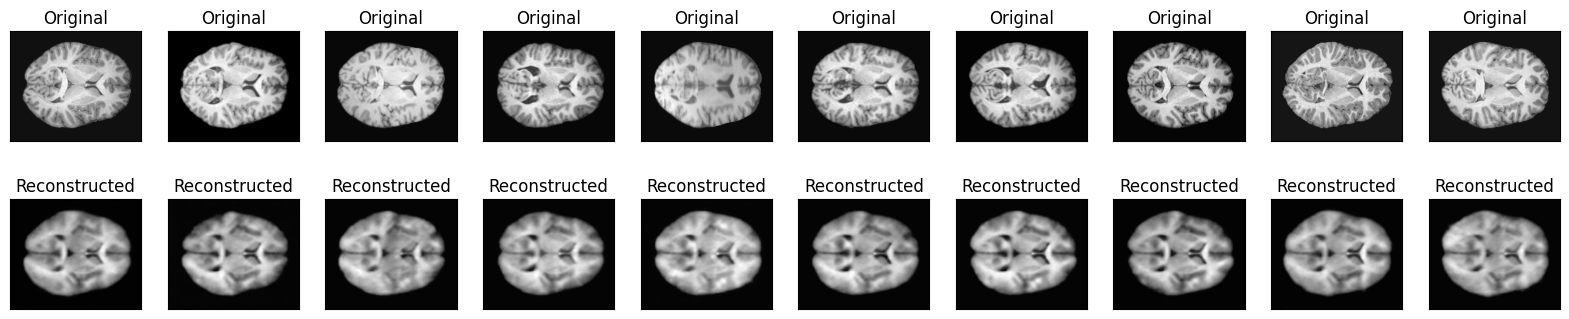

In [14]:
display(mat, reconstructed)

Text(0.5, 0, 'Reconstructed T1 Scan')

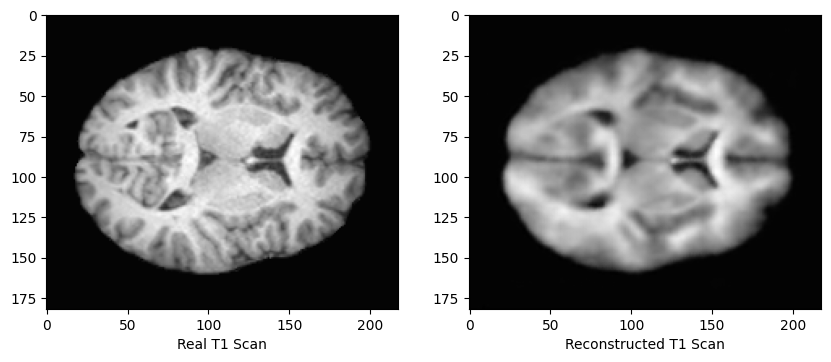

In [15]:
idx = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 15))
ax1.imshow(mat[idx], cmap = 'gray')
ax1.set_xlabel('Real T1 Scan')
ax2.imshow(reconstructed[idx], cmap = 'gray')
ax2.set_xlabel('Reconstructed T1 Scan')

In [16]:
# calculate rmse, excluding non-brain pixels

fltmsk = brain_mask.flatten()
nonzero_mat, nonzero_recon_mat = np.zeros((mat.shape[0], fltmsk[fltmsk == 1].shape[0])), np.zeros((mat.shape[0], fltmsk[fltmsk == 1].shape[0]))
for i in range(mat.shape[0]):
  tmpflt = reconstructed[i].flatten()
  nonzero_recon_mat[i] = tmpflt[fltmsk != 0]
  tmpflt = mat[i].flatten()
  nonzero_mat[i] = tmpflt[fltmsk != 0]
rms_arr = np.sqrt(((nonzero_mat - nonzero_recon_mat)**2).mean(axis=1))
df = pd.DataFrame(rms_arr, columns = ['RMSE'])


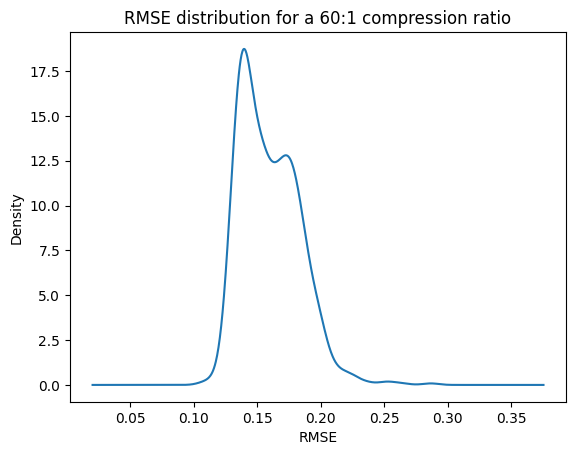

In [17]:
fig, ax = plt.subplots()

ax = df['RMSE'].plot.density(ax=ax)

ax.set_xlabel('RMSE')
ax.set_ylabel('Density')
ax.set_title('RMSE distribution for a 60:1 compression ratio')
plt.show()


In [18]:
from scipy.fft import fft2

recon_fft2, mat_fft2 = np.zeros((mat.shape[0], 182, 218)), np.zeros((mat.shape[0], 182, 218))
for i in range(mat.shape[0]):
  recon_fft2[i] = np.absolute(np.fft.fftshift(fft2(reconstructed[i, :, :, 0])))
  mat_fft2[i] = np.absolute(np.fft.fftshift(fft2(mat[i])))


Text(0.5, 0, 'Reconstructed Image Spectrum')

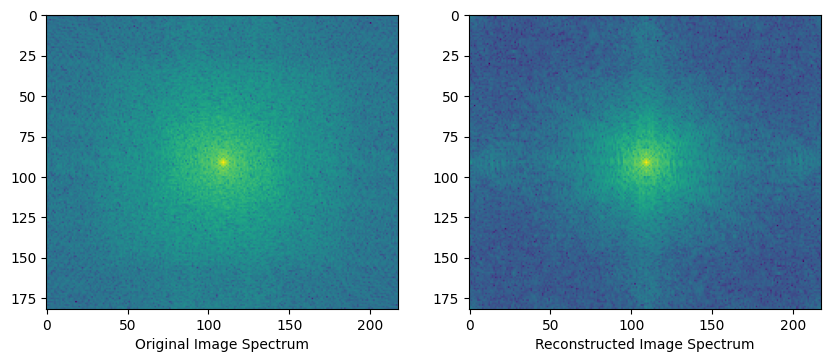

In [19]:
idx = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 15))
ax1.imshow(20*np.log(mat_fft2[idx]))
ax1.set_xlabel('Original Image Spectrum')
ax2.imshow(20*np.log(recon_fft2[idx]))
ax2.set_xlabel('Reconstructed Image Spectrum')
